# **Preprocess Data and Create Labels and Features**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

In [2]:
DATA_PATH = os.path.join('My_Datasets')

#sementara class dimana dan berapa tidak digunakan
#sementara class terimakasih ditiadakan (testing)
actions = np.array(['maaf', 'tolong', "nama", "saya", "kamu", "siapa", "rumah", "start", "standby", "delete", "translate"])

actions = np.array(['maaf', 'tolong', "terimakasih", "nama", "saya", "kamu"])

no_sequences = 30

sequence_length = 30

In [3]:
label_map = {label:num for num, label in enumerate(actions)}

In [4]:
label_map

{'maaf': 0, 'tolong': 1, 'terimakasih': 2, 'nama': 3, 'saya': 4, 'kamu': 5}

In [6]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}-norm.npy".format(frame_num)))
            
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [7]:
np.array(sequences).shape

(330, 30, 108)

In [8]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(231, 30, 108)
(99, 30, 108)
(231, 11)
(99, 11)


# **Build and Train LSTM Neural Network**

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [28]:
checkpoint = ModelCheckpoint('test.h5', monitor='categorical_accuracy', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False,save_freq='epoch')

In [29]:
# model = Sequential()

# model.add(TimeDistributed(Dense(units=256, activation='tanh'), input_shape=(30, 108)))
# model.add(LSTM(128, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(LSTM(64, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [110]:
model = Sequential()

model.add(TimeDistributed(Dense(units=256, activation='tanh'), input_shape=(30, 108)))
model.add(LSTM(128, return_sequences=False, activation='tanh', input_shape=(30,108)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(actions.shape[0], activation='softmax'))

In [408]:
# COMPLEX MODEL -> EXPERIMENTAL
# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.4))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [409]:
# COMPLEX MODEL 2

# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 30, 256)           27904     
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           197120    
                                                                 
 dropout_6 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                      

In [31]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [32]:
train_model = model.fit(X_train, y_train, epochs=40, callbacks=[checkpoint], validation_data=(X_test, y_test))

Epoch 1/40
7/8 [=========================>....] - ETA: 0s - loss: 2.1619 - categorical_accuracy: 0.2500 
Epoch 1: categorical_accuracy improved from -inf to 0.24675, saving model to test.h5
8/8 [==============================] - 3s 116ms/step - loss: 2.1553 - categorical_accuracy: 0.2468 - val_loss: 1.7617 - val_categorical_accuracy: 0.6970
Epoch 2/40
7/8 [=========================>....] - ETA: 0s - loss: 1.7239 - categorical_accuracy: 0.5446
Epoch 2: categorical_accuracy improved from 0.24675 to 0.54978, saving model to test.h5
8/8 [==============================] - 0s 38ms/step - loss: 1.7137 - categorical_accuracy: 0.5498 - val_loss: 1.3850 - val_categorical_accuracy: 0.7475
Epoch 3/40
7/8 [=========================>....] - ETA: 0s - loss: 1.3723 - categorical_accuracy: 0.6920
Epoch 3: categorical_accuracy improved from 0.54978 to 0.68398, saving model to test.h5
8/8 [==============================] - 1s 75ms/step - loss: 1.3808 - categorical_accuracy: 0.6840 - val_loss: 1.0706 - va

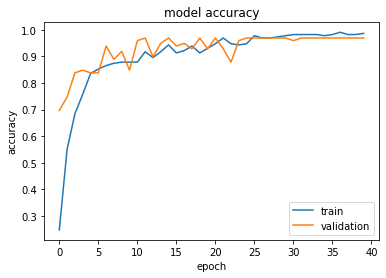

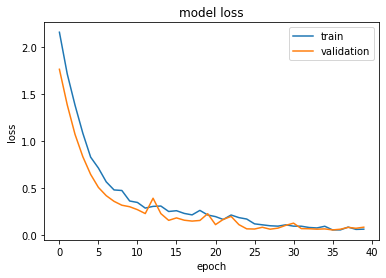

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 30, 256)           27904     
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           197120    
                                                                 
 dropout_6 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                      

In [33]:
# print(train_model.history.keys())

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# score, acc = model.evaluate(X_test,y_test,batch_size=32,verbose=0)
# print('Test performance: accuracy={0}, loss={1}'.format(acc, score)) 
# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)
    
model.summary()

In [34]:
model.save('model-bimbingan.h5')

# **Make Predictions**

In [35]:
res = model.predict(X_test)

4/4 [==============================] - 1s 9ms/step


In [36]:
actions[np.argmax(res[11])]

'translate'

In [37]:
actions[np.argmax(y_test[11])]

'translate'

# **Save Weights**

In [418]:
model.save('model.h5')

In [419]:
del model

In [38]:
# model.load_weights('model.h5')

model.load_weights('model-bimbingan.h5')

# **Evaluation using Confusion Matrix and Accuracy**

In [39]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [40]:
yhat = model.predict(X_test)

4/4 [==============================] - 0s 10ms/step


In [41]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [42]:
mcm = multilabel_confusion_matrix(ytrue, yhat)
print(mcm)

[[[88  0]
  [ 0 11]]

 [[90  0]
  [ 0  9]]

 [[90  0]
  [ 0  9]]

 [[86  0]
  [ 0 13]]

 [[86  3]
  [ 0 10]]

 [[90  0]
  [ 3  6]]

 [[93  0]
  [ 0  6]]

 [[91  0]
  [ 0  8]]

 [[94  0]
  [ 0  5]]

 [[89  0]
  [ 0 10]]

 [[90  0]
  [ 0  9]]]


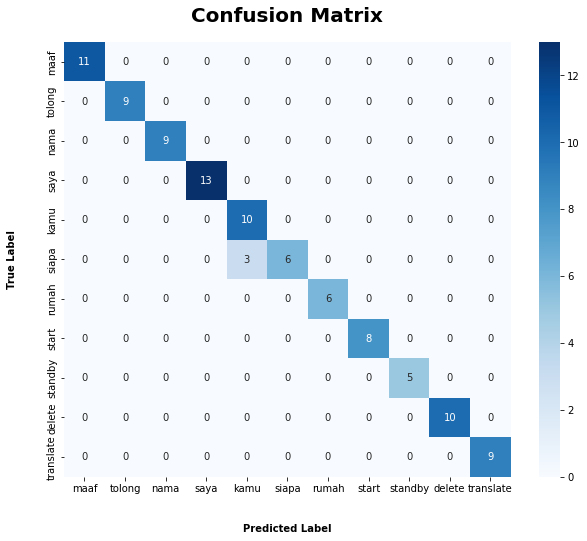

In [43]:
ytrue = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(10, 8))
heatMap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)

heatMap.set_xlabel('Predicted Label', labelpad=30, weight='bold')
heatMap.set_ylabel('True Label', labelpad=30, weight='bold')

heatMap.set_title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.show()

In [44]:
from sklearn.metrics import classification_report

# Assuming ytrue and yhat are the true and predicted labels, respectively
report = classification_report(ytrue, yhat, target_names=actions)
print(report)

              precision    recall  f1-score   support

        maaf       1.00      1.00      1.00        11
      tolong       1.00      1.00      1.00         9
        nama       1.00      1.00      1.00         9
        saya       1.00      1.00      1.00        13
        kamu       0.77      1.00      0.87        10
       siapa       1.00      0.67      0.80         9
       rumah       1.00      1.00      1.00         6
       start       1.00      1.00      1.00         8
     standby       1.00      1.00      1.00         5
      delete       1.00      1.00      1.00        10
   translate       1.00      1.00      1.00         9

    accuracy                           0.97        99
   macro avg       0.98      0.97      0.97        99
weighted avg       0.98      0.97      0.97        99



In [45]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming ytrue and yhat are the true and predicted labels, respectively
metrics = precision_recall_fscore_support(ytrue, yhat)

precision_per_class = metrics[0]
recall_per_class = metrics[1]
f1_score_per_class = metrics[2]

# Print metrics for each class
for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

# For accuracy per class, you would need to calculate it manually:
accuracy_per_class = [(conf_matrix[i, i] / np.sum(conf_matrix[:, i])) for i in range(len(actions))]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[i]}\n")

Class: maaf
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: tolong
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: nama
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: saya
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: kamu
Precision: 0.7692307692307693
Recall: 1.0
F1 Score: 0.8695652173913044

Class: siapa
Precision: 1.0
Recall: 0.6666666666666666
F1 Score: 0.8

Class: rumah
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: start
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: standby
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: delete
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: translate
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: maaf
Accuracy: 1.0

Class: tolong
Accuracy: 1.0

Class: nama
Accuracy: 1.0

Class: saya
Accuracy: 1.0

Class: kamu
Accuracy: 0.7692307692307693

Class: siapa
Accuracy: 1.0

Class: rumah
Accuracy: 1.0

Class: start
Accuracy: 1.0

Class: standby
Accuracy: 1.0

Class: delete
Accuracy: 1.0

Class: translate
Accuracy: 1.0

